In [1]:
from datetime import datetime
print("Current Date/Time: ", datetime.now())

Current Date/Time:  2020-05-30 16:53:51.722202


## Enabling Import of Custom Python Modules from Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/EVA4/S9')

In [0]:
from torch.utils.data import DataLoader, Dataset

In [4]:
from albumentations import *
from albumentations.pytorch import ToTensor
import data_preprocess_Albumentation_module_1
import resnet
import train_test_module_CrossEntropy
import gradcam_module
import QuizDNN

CUDA Available? True


In [0]:
from __future__ import print_function
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
%matplotlib inline
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensor

### Using GPU instead of CPU

In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? True


In [7]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=data_preprocess_Albumentation_module_1.albumentation_train())

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=data_preprocess_Albumentation_module_1.albumentation_test())

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



In [0]:
trainloader, testloader = data_preprocess_Albumentation_module_1.get_train_test_loader(trainset, testset)

plane   dog  deer  deer


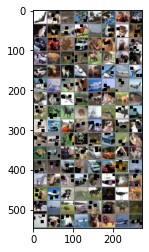

In [9]:
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [10]:
images.shape

torch.Size([128, 3, 32, 32])

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [11]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
net = QuizDNN.QuizDNN().to(device)
summary(net, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
           Dropout-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
              ReLU-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          36,864
             ReLU-10           [-1, 64, 32, 32]               0
      BatchNorm2d-11           [-1, 64, 32, 32]             128
          Dropout-12           [-1, 64, 32, 32]               0
        MaxPool2d-13           [-1, 64, 16, 16]               0
           Conv2d-14           [-1

In [12]:
def test():
    net = resnet.ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())
test()

torch.Size([1, 10])


In [13]:
from torch.optim.lr_scheduler import StepLR

net =  QuizDNN.QuizDNN().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.05, momentum=0.9, weight_decay=0.0005)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

EPOCHS = 35
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_test_module_CrossEntropy.train(net, device, trainloader, optimizer, epoch)
    scheduler.step()
    train_test_module_CrossEntropy.test(net, device, testloader)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.091020941734314 Batch_id=390 Accuracy=47.70: 100%|██████████| 391/391 [00:49<00:00,  7.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -3.5287, Accuracy: 5885/10000 (58.85%)

EPOCH: 1


Loss=0.9049468040466309 Batch_id=390 Accuracy=63.78: 100%|██████████| 391/391 [00:49<00:00,  7.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.1521, Accuracy: 6881/10000 (68.81%)

EPOCH: 2


Loss=0.9114252924919128 Batch_id=390 Accuracy=70.09: 100%|██████████| 391/391 [00:49<00:00,  7.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.9722, Accuracy: 7166/10000 (71.66%)

EPOCH: 3


Loss=0.6381200551986694 Batch_id=390 Accuracy=74.09: 100%|██████████| 391/391 [00:49<00:00,  7.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.3014, Accuracy: 7509/10000 (75.09%)

EPOCH: 4


Loss=1.053558588027954 Batch_id=390 Accuracy=76.30: 100%|██████████| 391/391 [00:49<00:00,  7.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.6530, Accuracy: 7750/10000 (77.50%)

EPOCH: 5


Loss=0.8925525546073914 Batch_id=390 Accuracy=77.81: 100%|██████████| 391/391 [00:49<00:00,  7.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.4976, Accuracy: 7958/10000 (79.58%)

EPOCH: 6


Loss=0.7770316004753113 Batch_id=390 Accuracy=79.30: 100%|██████████| 391/391 [00:49<00:00,  7.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.6598, Accuracy: 7985/10000 (79.85%)

EPOCH: 7


Loss=0.5745882987976074 Batch_id=390 Accuracy=79.99: 100%|██████████| 391/391 [00:49<00:00,  7.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.0546, Accuracy: 8156/10000 (81.56%)

EPOCH: 8


Loss=0.4948616027832031 Batch_id=390 Accuracy=80.50: 100%|██████████| 391/391 [00:49<00:00,  7.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.6234, Accuracy: 8001/10000 (80.01%)

EPOCH: 9


Loss=0.4998384416103363 Batch_id=390 Accuracy=81.14: 100%|██████████| 391/391 [00:49<00:00,  7.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.1453, Accuracy: 7951/10000 (79.51%)

EPOCH: 10


Loss=0.5779760479927063 Batch_id=390 Accuracy=84.06: 100%|██████████| 391/391 [00:49<00:00,  7.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.8376, Accuracy: 8412/10000 (84.12%)

EPOCH: 11


Loss=0.3988693356513977 Batch_id=390 Accuracy=84.54: 100%|██████████| 391/391 [00:48<00:00,  7.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.8907, Accuracy: 8393/10000 (83.93%)

EPOCH: 12


Loss=0.3865421414375305 Batch_id=390 Accuracy=84.99: 100%|██████████| 391/391 [00:49<00:00,  7.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.1039, Accuracy: 8532/10000 (85.32%)

EPOCH: 13


Loss=0.5910927057266235 Batch_id=390 Accuracy=85.25: 100%|██████████| 391/391 [00:49<00:00,  7.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.5895, Accuracy: 8508/10000 (85.08%)

EPOCH: 14


Loss=0.6448729038238525 Batch_id=390 Accuracy=85.32: 100%|██████████| 391/391 [00:49<00:00,  7.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.3606, Accuracy: 8572/10000 (85.72%)

EPOCH: 15


Loss=0.521361768245697 Batch_id=390 Accuracy=85.51: 100%|██████████| 391/391 [00:49<00:00,  7.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.3361, Accuracy: 8422/10000 (84.22%)

EPOCH: 16


Loss=0.376377671957016 Batch_id=390 Accuracy=85.81: 100%|██████████| 391/391 [00:49<00:00,  7.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.0371, Accuracy: 8479/10000 (84.79%)

EPOCH: 17


Loss=0.43688100576400757 Batch_id=390 Accuracy=85.67: 100%|██████████| 391/391 [00:49<00:00,  7.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.2890, Accuracy: 8574/10000 (85.74%)

EPOCH: 18


Loss=0.4867880940437317 Batch_id=390 Accuracy=85.88: 100%|██████████| 391/391 [00:48<00:00,  8.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.5342, Accuracy: 8541/10000 (85.41%)

EPOCH: 19


Loss=0.25615766644477844 Batch_id=390 Accuracy=85.92: 100%|██████████| 391/391 [00:48<00:00,  8.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.4433, Accuracy: 8595/10000 (85.95%)

EPOCH: 20


Loss=0.28664129972457886 Batch_id=390 Accuracy=88.20: 100%|██████████| 391/391 [00:48<00:00,  8.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.9314, Accuracy: 8720/10000 (87.20%)

EPOCH: 21


Loss=0.44616204500198364 Batch_id=390 Accuracy=88.63: 100%|██████████| 391/391 [00:48<00:00,  8.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.2174, Accuracy: 8747/10000 (87.47%)

EPOCH: 22


Loss=0.4563348889350891 Batch_id=390 Accuracy=88.84: 100%|██████████| 391/391 [00:48<00:00,  8.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.1067, Accuracy: 8727/10000 (87.27%)

EPOCH: 23


Loss=0.24607177078723907 Batch_id=390 Accuracy=89.04: 100%|██████████| 391/391 [00:48<00:00,  8.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.8495, Accuracy: 8751/10000 (87.51%)

EPOCH: 24


Loss=0.21000389754772186 Batch_id=390 Accuracy=89.00: 100%|██████████| 391/391 [00:48<00:00,  8.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.0037, Accuracy: 8704/10000 (87.04%)

EPOCH: 25


Loss=0.24252863228321075 Batch_id=390 Accuracy=89.02: 100%|██████████| 391/391 [00:48<00:00,  8.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.9100, Accuracy: 8748/10000 (87.48%)

EPOCH: 26


Loss=0.37051862478256226 Batch_id=390 Accuracy=89.31: 100%|██████████| 391/391 [00:48<00:00,  8.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.0326, Accuracy: 8713/10000 (87.13%)

EPOCH: 27


Loss=0.20996229350566864 Batch_id=390 Accuracy=89.10: 100%|██████████| 391/391 [00:48<00:00,  8.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.1831, Accuracy: 8788/10000 (87.88%)

EPOCH: 28


Loss=0.39190635085105896 Batch_id=390 Accuracy=89.24: 100%|██████████| 391/391 [00:48<00:00,  8.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.3056, Accuracy: 8745/10000 (87.45%)

EPOCH: 29


Loss=0.23739707469940186 Batch_id=390 Accuracy=89.26: 100%|██████████| 391/391 [00:48<00:00,  8.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.2920, Accuracy: 8682/10000 (86.82%)

EPOCH: 30


Loss=0.26702237129211426 Batch_id=390 Accuracy=90.84: 100%|██████████| 391/391 [00:48<00:00,  8.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.6890, Accuracy: 8839/10000 (88.39%)

EPOCH: 31


Loss=0.37216806411743164 Batch_id=390 Accuracy=91.01: 100%|██████████| 391/391 [00:48<00:00,  8.05it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.6408, Accuracy: 8854/10000 (88.54%)

EPOCH: 32


Loss=0.14272479712963104 Batch_id=390 Accuracy=91.31: 100%|██████████| 391/391 [00:48<00:00,  8.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -10.0352, Accuracy: 8867/10000 (88.67%)

EPOCH: 33


Loss=0.18126583099365234 Batch_id=390 Accuracy=91.46: 100%|██████████| 391/391 [00:48<00:00,  8.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -10.0239, Accuracy: 8800/10000 (88.00%)

EPOCH: 34


Loss=0.2965012192726135 Batch_id=390 Accuracy=91.52: 100%|██████████| 391/391 [00:48<00:00,  8.06it/s]



Test set: Average loss: -9.9396, Accuracy: 8858/10000 (88.58%)



5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



GroundTruth:    cat  ship  ship plane


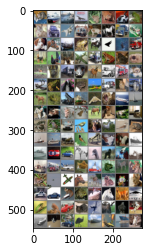

In [14]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [0]:
outputs = net(images.cuda())

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [16]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [17]:
correct = 0
total = 0
with torch.no_grad():
    for data, target in testloader:
        images, labels = data.to(device), target.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 88 %


That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [18]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data, target in testloader:
        images, labels = data.to(device), target.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 93 %
Accuracy of   car : 96 %
Accuracy of  bird : 84 %
Accuracy of   cat : 70 %
Accuracy of  deer : 88 %
Accuracy of   dog : 72 %
Accuracy of  frog : 86 %
Accuracy of horse : 88 %
Accuracy of  ship : 87 %
Accuracy of truck : 92 %


## GradCam 

In [0]:
target_layers = ["x3_block","x5_block","x7_block","x11_block"]
viz_cam = gradcam_module.VisualizeCam(net,classes, target_layers)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


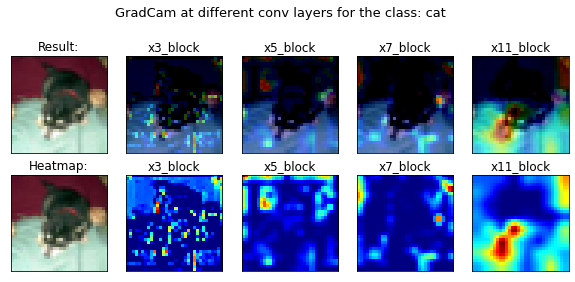

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


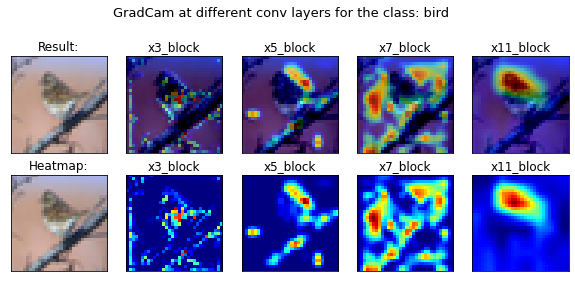

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


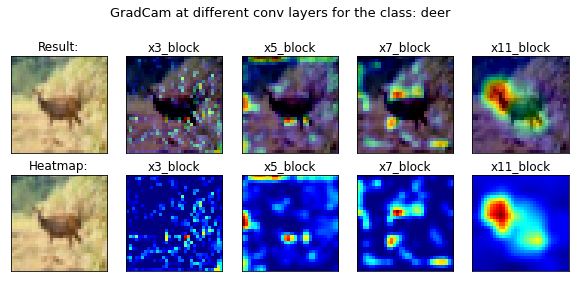

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


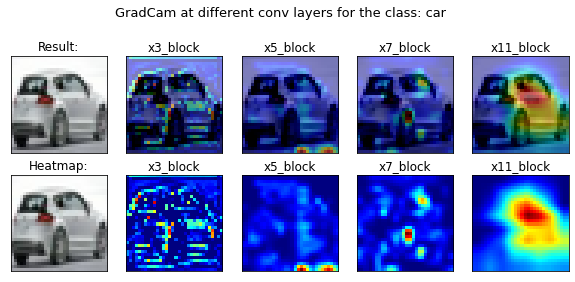

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


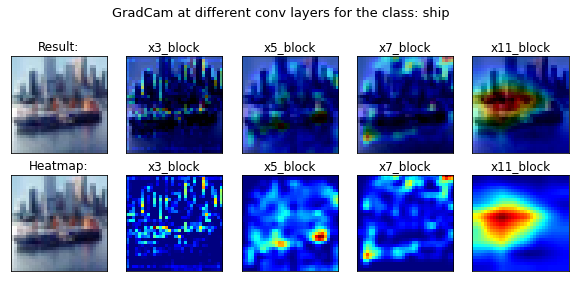

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


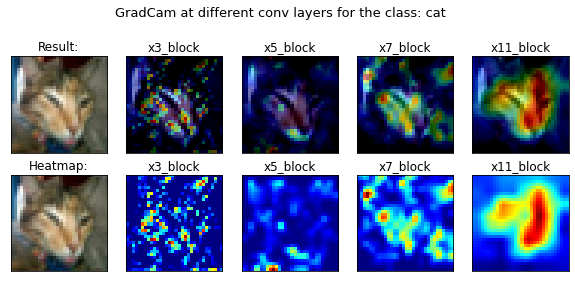

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


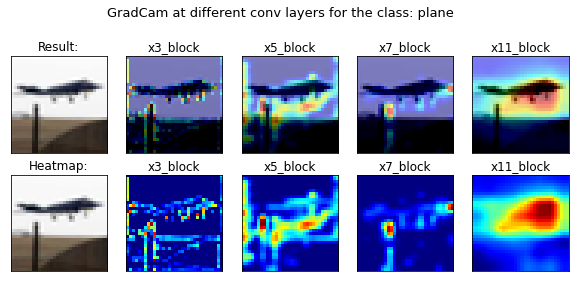

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


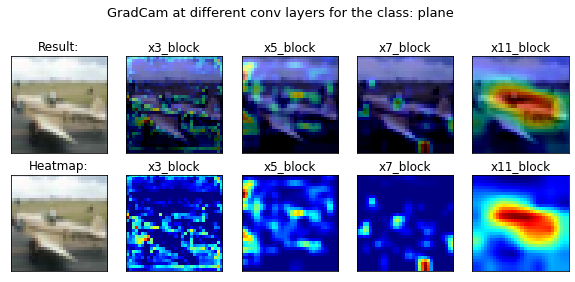

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


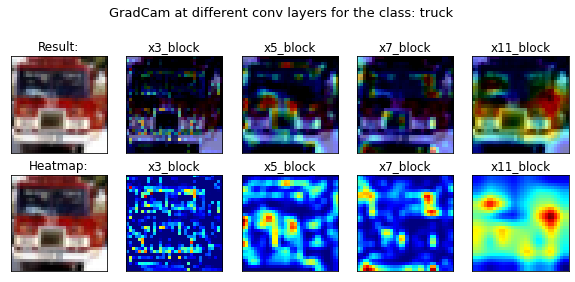

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


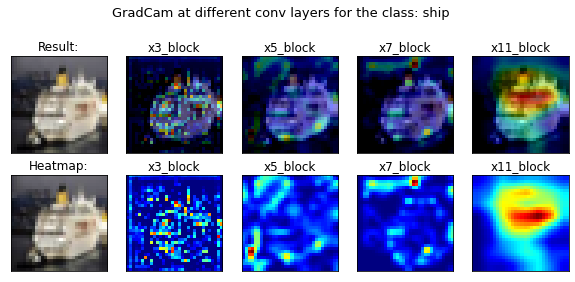

In [26]:
correct_pred_imgs = []
dataiter = iter(testloader)
images, labels = dataiter.next()
for i in range(2):
  images, labels = dataiter.next()
  viz_cam( images, target_layers)